In [1]:
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt
import re
import h5py
from six.moves import range

from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
## for Palatino and other serif fonts use:
#rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=True)
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
%matplotlib inline

In [2]:
def compute_purity_via_row_norm(arr):
    pur_arr = np.zeros_like(arr)
    pur_arr_err = np.zeros_like(arr)
    for i in range(np.shape(arr)[0]):
        npass = arr[i, :]
        ntotal = arr.sum(axis=1)[i]
        epsilon = npass / ntotal
        pur_arr[i, :] = epsilon
        pur_arr_err[i, :] = np.sqrt(epsilon * (1 - epsilon) / ntotal)
        
    return pur_arr, pur_arr_err

In [3]:
def compute_effic_via_col_norm(arr):
    eff_arr = np.zeros_like(arr)
    eff_arr_err = np.zeros_like(arr)
    for i in range(np.shape(arr)[0]):
        npass = arr[:, i]
        ntotal = arr.sum(axis=0)[i]
        epsilon = npass / ntotal
        eff_arr[:, i] = epsilon
        eff_arr_err[i, :] = np.sqrt(epsilon * (1 - epsilon) / ntotal)
        
    return eff_arr, eff_arr_err

In [4]:
def make_plots_raw(arr, plot_type, colormap='Reds'):
    """
    plots and text for confusion matrices
    """
    fig = plt.figure(figsize=(16,16))
    gs = plt.GridSpec(1, 2)

    def make_title_string(title, logscale):
        title = r'Log$_{10}$ ' + title if logscale else title
        return title
    
    def make_subplot(ax, show_arr, colormap, title):
        im = ax.imshow(show_arr, cmap=plt.get_cmap(colormap), interpolation='nearest', origin='lower')
        cbar = plt.colorbar(im, fraction=0.04)
        plt.title(title)
        plt.xlabel('True z-segment')
        plt.ylabel('Reconstructed z-segment')
        
    # linear plots
    ax = plt.subplot(gs[0])
    show_arr = arr
    make_subplot(ax, show_arr, colormap, make_title_string('Confustion matrix', False))

    # log plots
    ax = plt.subplot(gs[1])
    show_arr = np.log10(arr * 100.0)
    make_subplot(ax, show_arr, colormap, make_title_string('Confustion matrix', True))
    
    fig.savefig('confusion_matrices_raw_{}.pdf'.format(plot_type), bbox_inches='tight')

In [5]:
def make_plots_rowcolnormonly(
    arr, plot_type, top_title='Purity', bottom_title='Efficiency', colormap='Reds', 
    print_arrays=False, print_targets=True
):
    """
    plots and text for confusion matrices
    """
    target_plane_codes = {9: 1, 18: 2, 27: 3, 44: 4, 49: 5}
    fig = plt.figure(figsize=(16,16))
    gs = plt.GridSpec(2, 2)

    # purity calc
    pur_arr, pur_arr_err = compute_purity_via_row_norm(arr)
    eff_arr, eff_arr_err = compute_effic_via_col_norm(arr)

    if print_arrays:
        print("purity (row-normalized diagonal values)")
        for i in range(pur_arr.shape[0]):
            print('segment {:2d}: purity = {:.3f}'.format(i, pur_arr[i, i]))
        print("efficiency (column-normalized diagonal values)")
        for i in range(eff_arr.shape[0]):
            print('segment {:2d}: efficiency = {:.3f}'.format(i, eff_arr[i, i]))
    
    if print_targets:
        print("purity (row-normalized diagonal values)")
        for i in target_plane_codes.keys():
            print('target {:2d}: purity = {:.3f} +/- {:.3f} (stat)'.format(
                target_plane_codes[i], pur_arr[i, i], pur_arr_err[i, i]
            ))
        print("efficiency (column-normalized diagonal values)")
        for i in target_plane_codes.keys():
            print('target {:2d}: efficiency = {:.3f} +/- {:.3f} (stat)'.format(
                target_plane_codes[i], eff_arr[i, i], eff_arr_err[i, i]
            ))

    
    def make_title_string(title_base, title_mod, logscale):
        title = title_base.format(title_mod)
        title = r'Log$_{10}$ ' + title if logscale else title
        return title
    
    def make_subplot(ax, show_arr, colormap, title):
        im = ax.imshow(show_arr, cmap=plt.get_cmap(colormap), interpolation='nearest', origin='lower')
        cbar = plt.colorbar(im, fraction=0.04)
        plt.title(title)
        plt.xlabel('True z-segment')
        plt.ylabel('Reconstructed z-segment')
        
    # purity linear plots
    ax = plt.subplot(gs[0])
    show_arr = pur_arr
    make_subplot(ax, show_arr, colormap, make_title_string('Purity (row normalized)\n{}', top_title, False))

    # purity log plots
    ax = plt.subplot(gs[1])
    show_arr = np.log10(pur_arr * 100.0)
    make_subplot(ax, show_arr, colormap, make_title_string('Purity (row normalized)\n{}', top_title, True))
    
    # efficiency linear plots
    ax = plt.subplot(gs[2])
    show_arr = eff_arr
    make_subplot(ax, show_arr, colormap, make_title_string('Efficiency (column normalized)\n{}', bottom_title, False))

    # efficiency log plots
    ax = plt.subplot(gs[3])
    show_arr = np.log10(eff_arr * 100.0)
    make_subplot(ax, show_arr, colormap, make_title_string('Efficiency (column normalized)\n{}', bottom_title, True))

    fig.savefig('confusion_matrices_rowcolnorm_{}.pdf'.format(plot_type), bbox_inches='tight')

In [12]:
#npy_name = '/Users/perdue/Documents/MINERvA/AI/minerva_tf/models/173/20170927_me1Amc_planecodes173'
#npy_name = '/Users/perdue/Documents/MINERvA/AI/minerva_tf/models/67/20170920_me1Amc_planecodes67'
#npy_name = '/Users/perdue/Documents/MINERvA/AI/minerva_tf/models/67/20170929_AdaGrad_me1Amc_planecodes67'
#npy_name = '/Users/perdue/Documents/MINERvA/AI/minerva_tf/models/67/20171001_Adam_me1Amc_planecodes67'
#npy_name = '/Users/perdue/Documents/MINERvA/AI/minerva_tf/models/173/20171001_Adam_me1Amc_planecodes173'
#npy_name = '/Users/perdue/Documents/MINERvA/AI/minerva_tf/models/173/20171001_Adam_me1ABmc_planecodes173'
npy_name = '/Users/perdue/Documents/MINERvA/AI/minerva_tf/models/173/collab_mtg_173'

#npy_name += '/confusion_matrix_trainA_testA.npy'
npy_name += '/confusion_matrix_trainA_testG.npy'

#npy_name = '/Users/perdue/Documents/MINERvA/AI/minerva_tf/models/67/perfmat67_1506636381_2f4b6202cd5d.npy'

arr = np.load(npy_name)

# for theano, think I need to transpose the axes for proper interp.
#arr = arr.transpose()

print(arr.shape)

(173, 173)


In [6]:
#plot_type_base = 'confusion_matrix_trainA_testA_'
plot_type_base = 'confusion_matrix_trainA_testG_'

/Users/perdue/miniconda2/envs/py2mnv_pda/lib/python2.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in divide
  import sys
/Users/perdue/miniconda2/envs/py2mnv_pda/lib/python2.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in log10
/Users/perdue/miniconda2/envs/py2mnv_pda/lib/python2.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: divide by zero encountered in log10


purity (row-normalized diagonal values)
target  1: purity = 0.803 +/- 0.002 (stat)
target  2: purity = 0.835 +/- 0.002 (stat)
target  3: purity = 0.838 +/- 0.002 (stat)
target  4: purity = 0.745 +/- 0.003 (stat)
target  5: purity = 0.807 +/- 0.002 (stat)
efficiency (column-normalized diagonal values)
target  1: efficiency = 0.967 +/- 0.001 (stat)
target  2: efficiency = 0.967 +/- 0.001 (stat)
target  3: efficiency = 0.947 +/- 0.001 (stat)
target  4: efficiency = 0.933 +/- 0.002 (stat)
target  5: efficiency = 0.931 +/- 0.001 (stat)


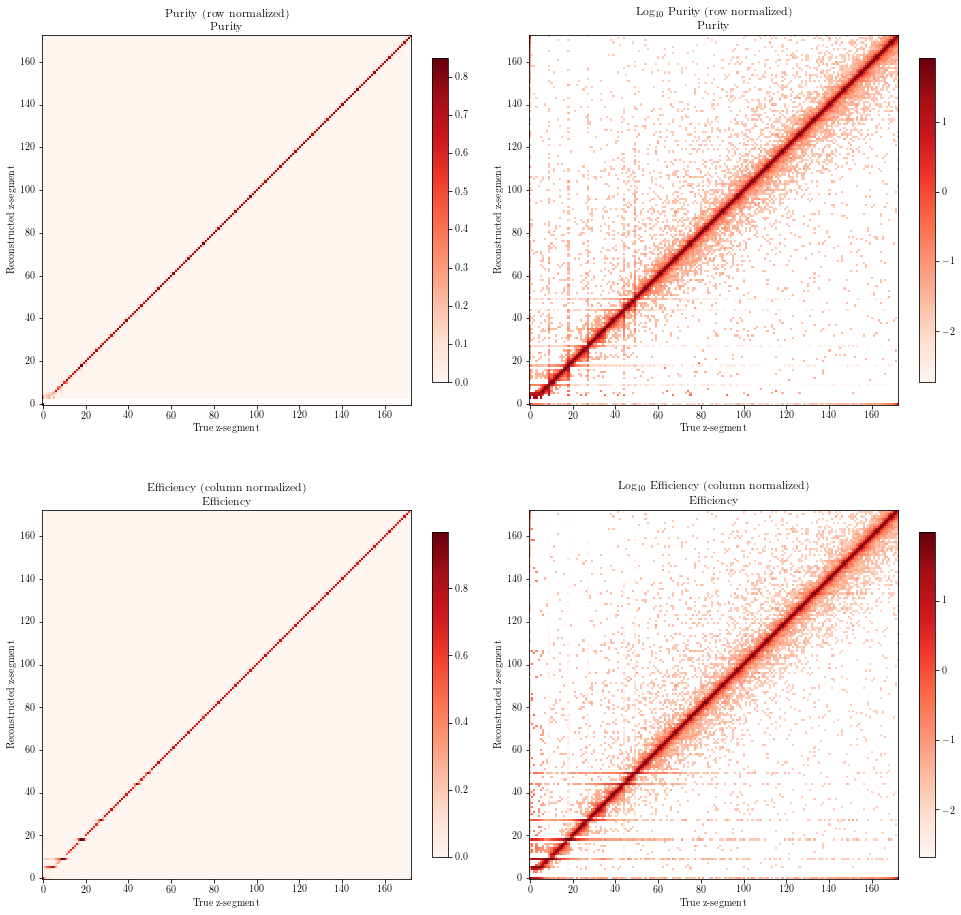

In [14]:
#plot_type = 'planecode_energy_only_me1Btest'
plot_type = plot_type_base + str(arr.shape[0])
make_plots_rowcolnormonly(arr, plot_type)

/Users/perdue/miniconda2/envs/py2mnv_pda/lib/python2.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log10


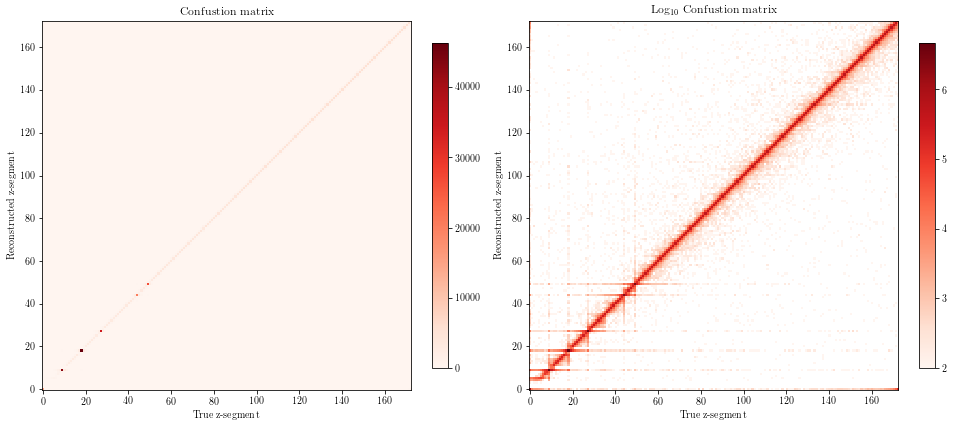

In [15]:
#plot_type = 'planecode_energytime_m1Btest'
plot_type = plot_type_base + str(arr.shape[0])
make_plots_raw(arr, plot_type)

In [16]:
np.sum(arr)

1096894.0

In [17]:
arr_sums = np.sum(arr, axis=0)
arr_total = np.sum(arr)
arr_fracs = arr_sums / arr_total
print(arr_fracs)

[ 0.01605807  0.00034552  0.00038837  0.00051053  0.00072569  0.00109217
  0.00150334  0.00298114  0.00326741  0.04041867  0.00349168  0.00343515
  0.00347436  0.00354273  0.00352359  0.00357737  0.00370774  0.00359105
  0.04364779  0.00357099  0.00353635  0.00352632  0.00362569  0.00365031
  0.00367857  0.00366398  0.00368222  0.03307065  0.00389372  0.00380438
  0.00376153  0.00378068  0.00378068  0.00394295  0.00379617  0.00399309
  0.00404415  0.00403959  0.0041499   0.00417998  0.00413075  0.00413805
  0.00405782  0.00423104  0.01989071  0.00420551  0.00420916  0.0042201
  0.00422101  0.02610188  0.00417087  0.00426386  0.00426842  0.00434317
  0.00442887  0.00442066  0.00443434  0.00445531  0.00445713  0.00443525
  0.00448539  0.00447081  0.00453098  0.00441975  0.00452095  0.00468049
  0.00451821  0.00471422  0.00464949  0.00471513  0.00470055  0.00470602
  0.00479992  0.0047516   0.0047753   0.00479809  0.00475069  0.00480903
  0.00476801  0.00478351  0.00477166  0.00486191  0.

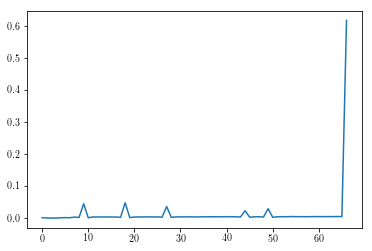

In [10]:
plt.plot(np.arange(67), arr_fracs)

In [11]:
true_downstrm_miss = np.sum(arr[66,0:65])   # real 66 reco'd elsewhere
arr_total = np.sum(arr)
true_downstrm_miss_frac = true_downstrm_miss / arr_total
print(true_downstrm_miss_frac)

0.00295111


In [12]:
pred_downstrm_miss = np.sum(arr[0:65,66])   # real target region reco'd downstream
arr_total = np.sum(arr)
pred_downstrm_miss_frac = pred_downstrm_miss / arr_total
print(pred_downstrm_miss_frac)

0.0176614


In [13]:
def do_plots(typ):
    arr_name = 'arr_' + typ + '.npy'
    arr = np.load(arr_name)
    filename_mod_str = 'me1A_' + typ
    plot_type = 'planecode_energy_only_' + filename_mod_str
    make_plots_rowcolnormonly(arr, plot_type)
    plot_type = 'planecode_energytime_' + filename_mod_str
    make_plots_raw(arr, plot_type)

In [19]:
typs = ['all', 'lowQ2', 'highQ2', 'lowW', 'highW', 'lowE', 'highE']

/Users/gnperdue/miniconda2/envs/py2mnv_pda/lib/python2.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in divide
  import sys
/Users/gnperdue/miniconda2/envs/py2mnv_pda/lib/python2.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in log10
/Users/gnperdue/miniconda2/envs/py2mnv_pda/lib/python2.7/site-packages/ipykernel_launcher.py:49: RuntimeWarning: divide by zero encountered in log10
/Users/gnperdue/miniconda2/envs/py2mnv_pda/lib/python2.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log10


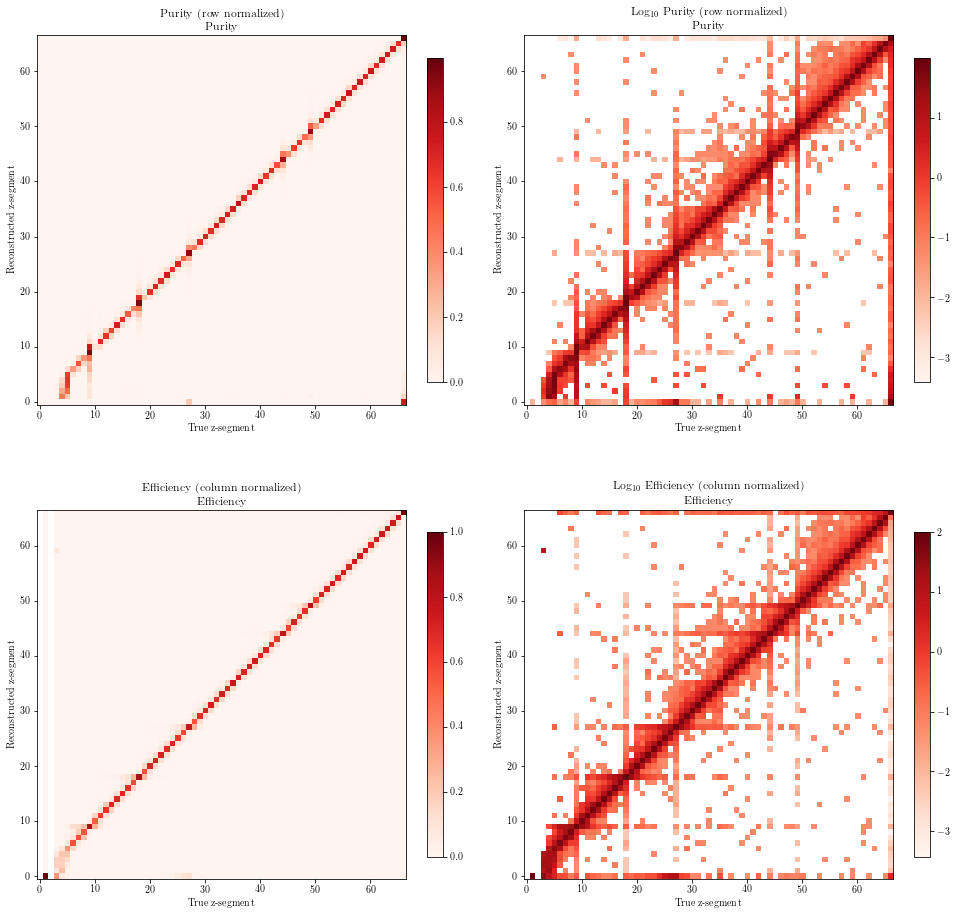

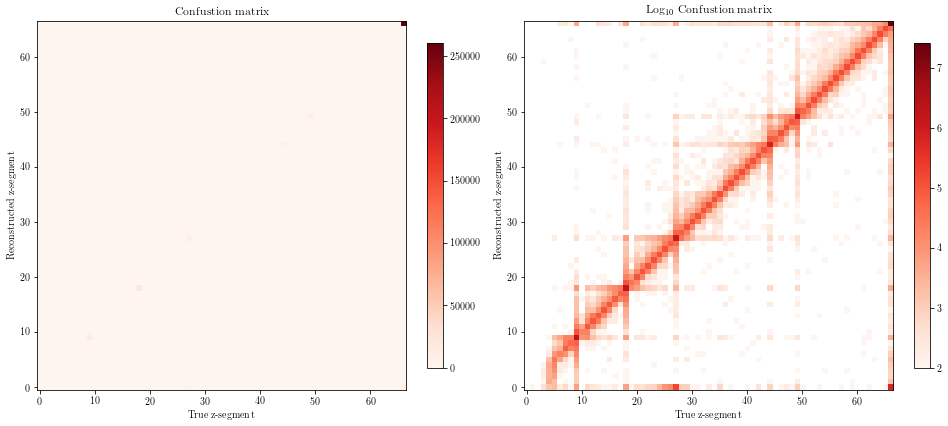

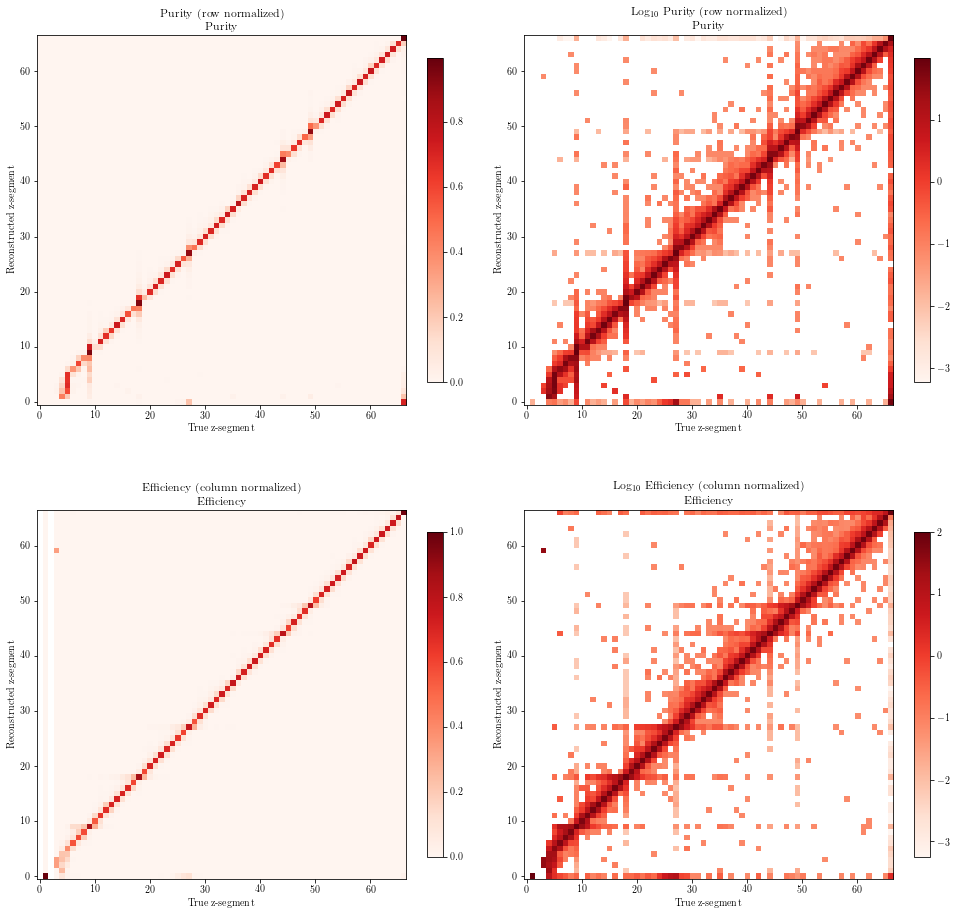

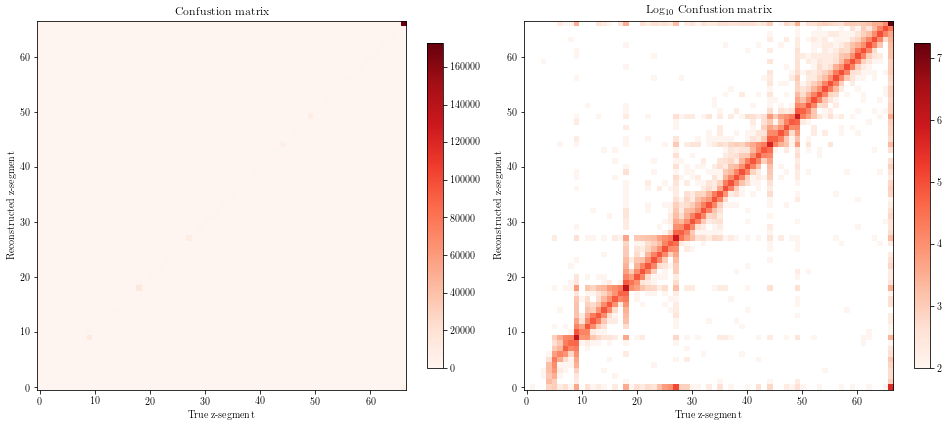

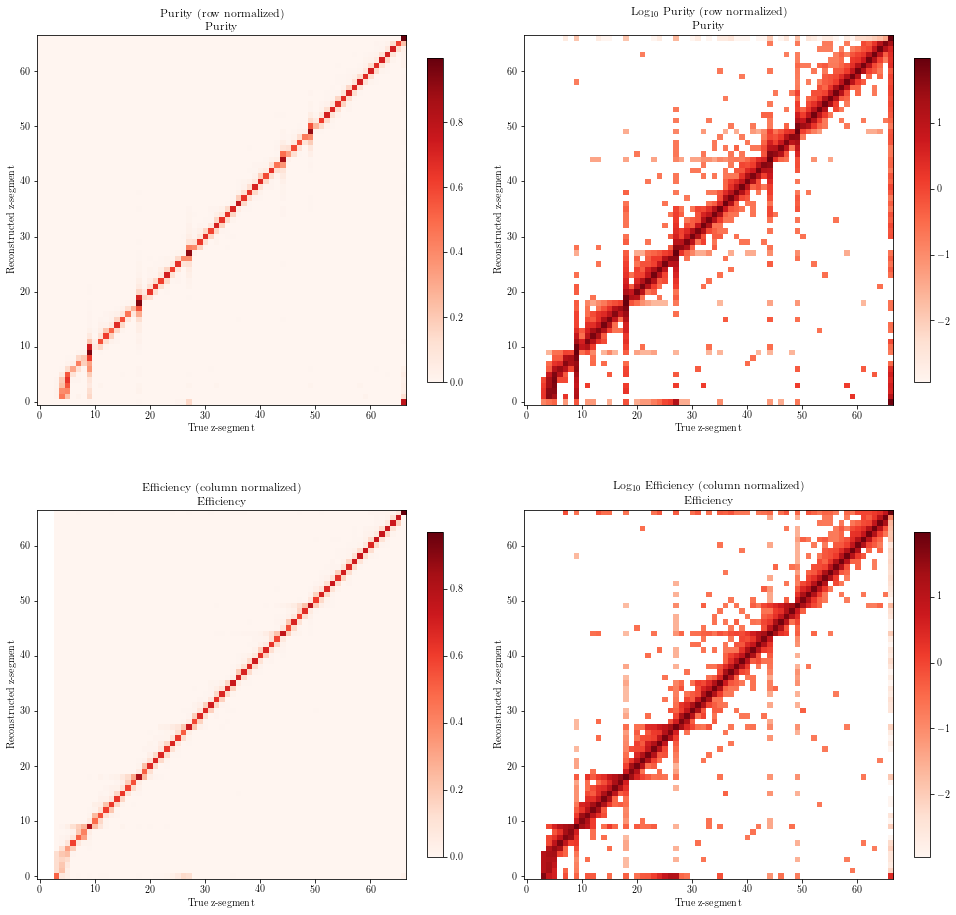

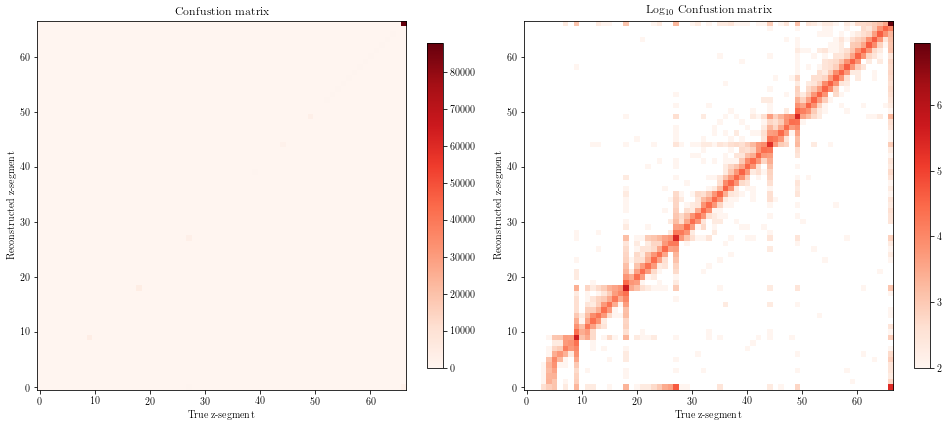

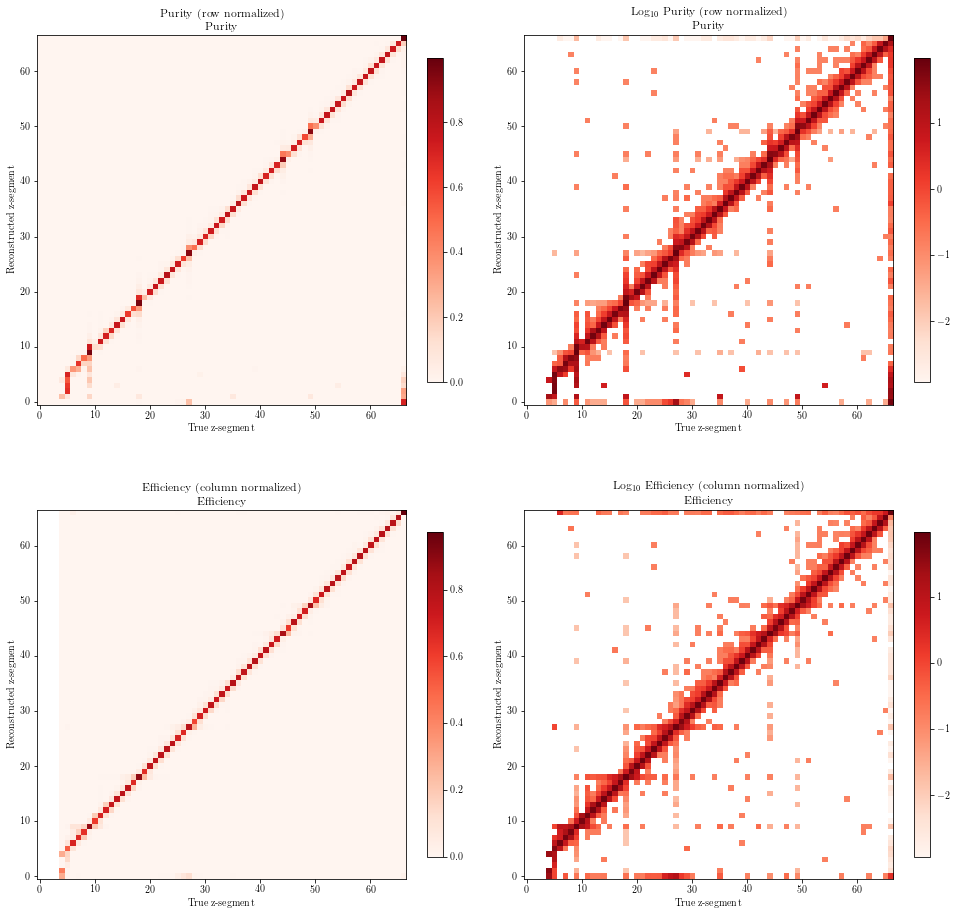

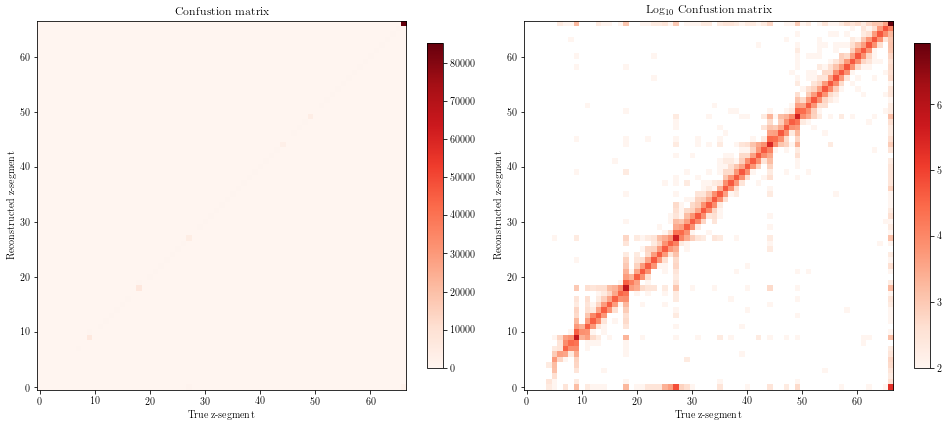

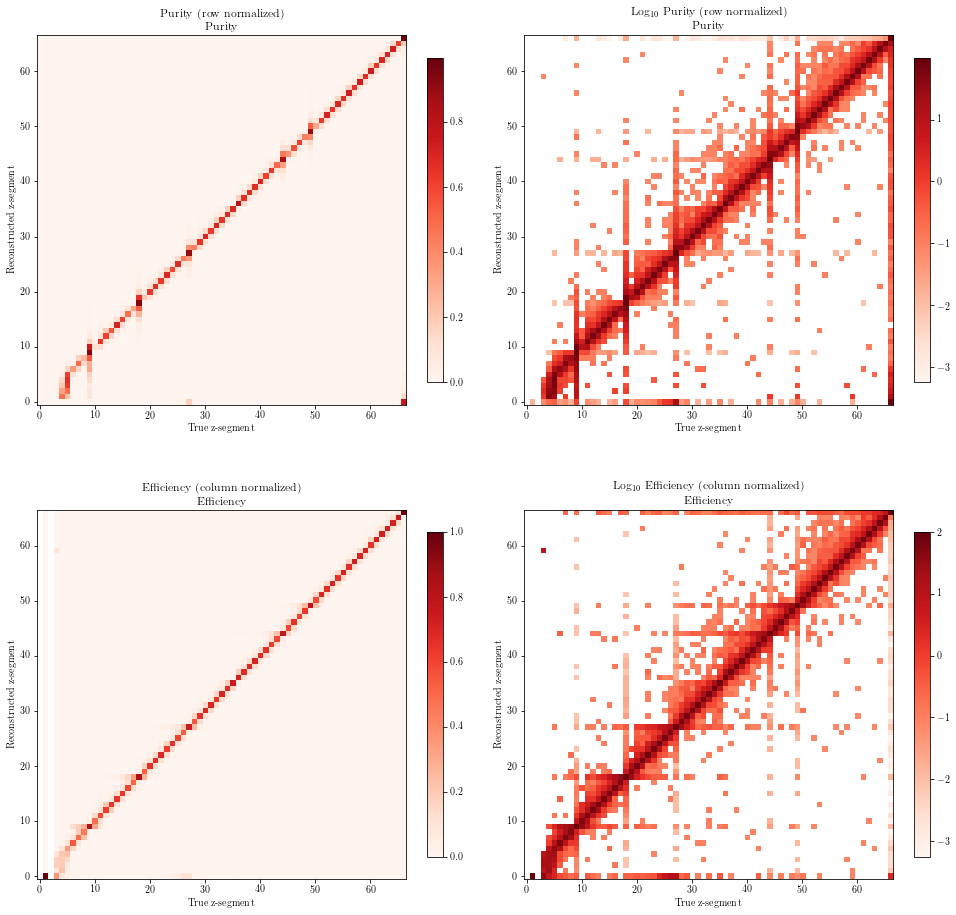

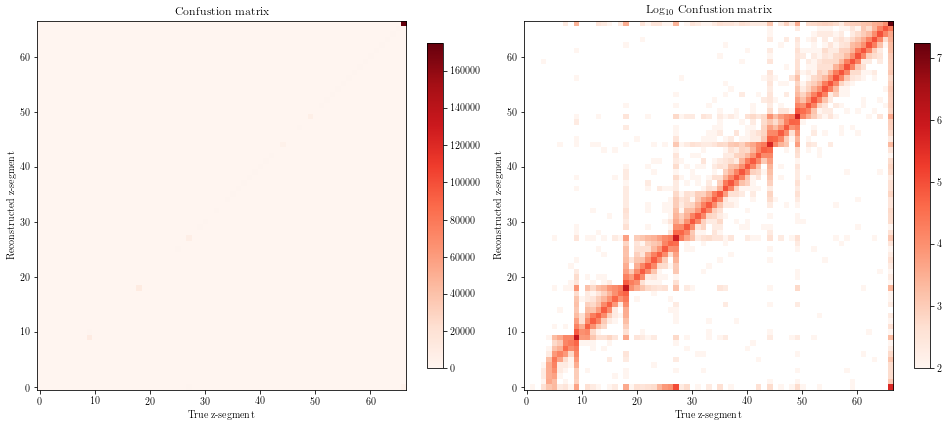

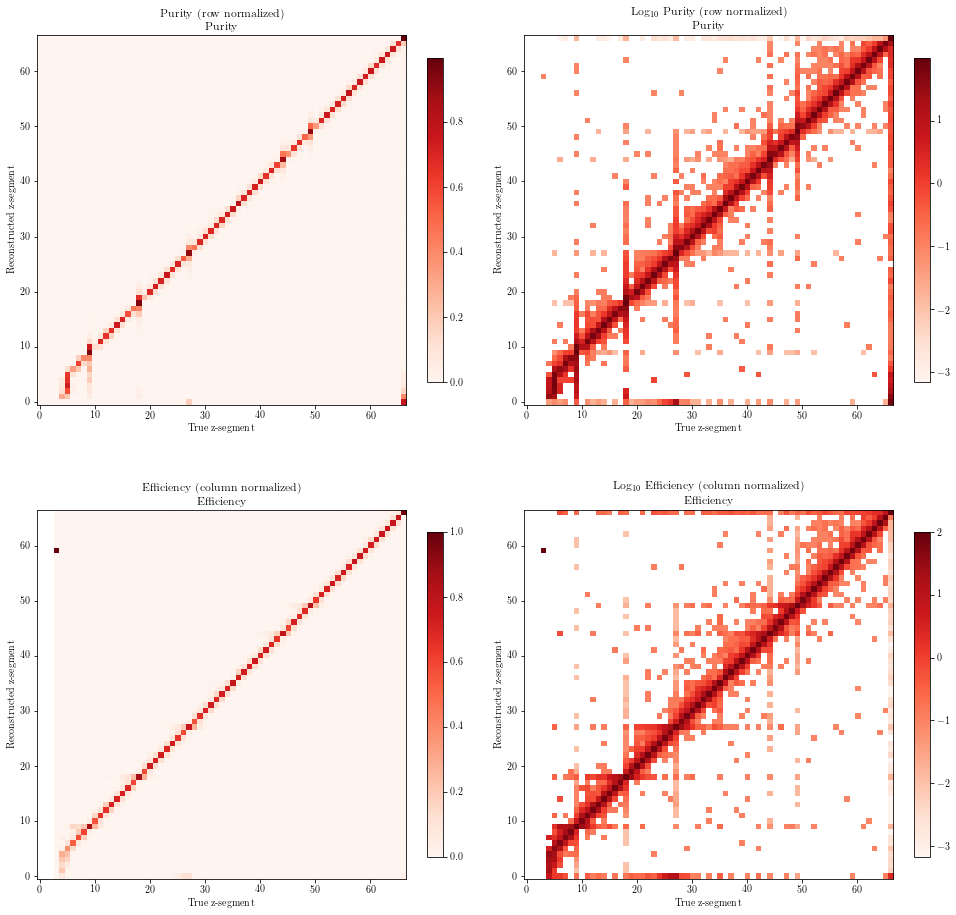

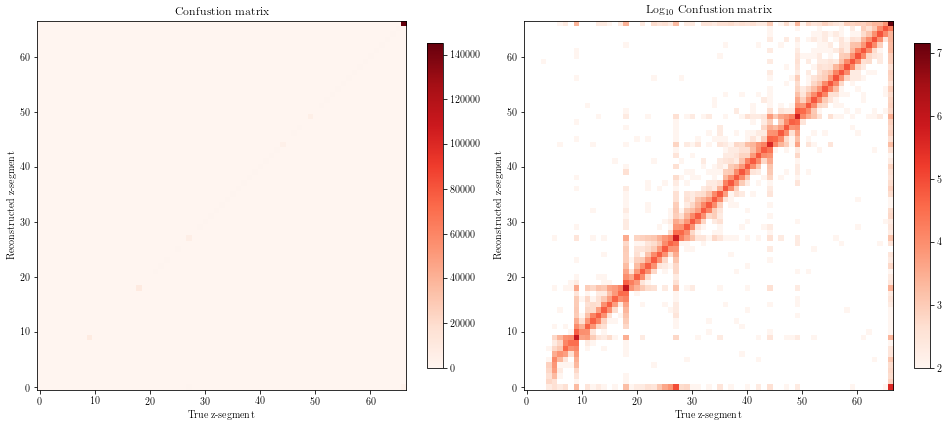

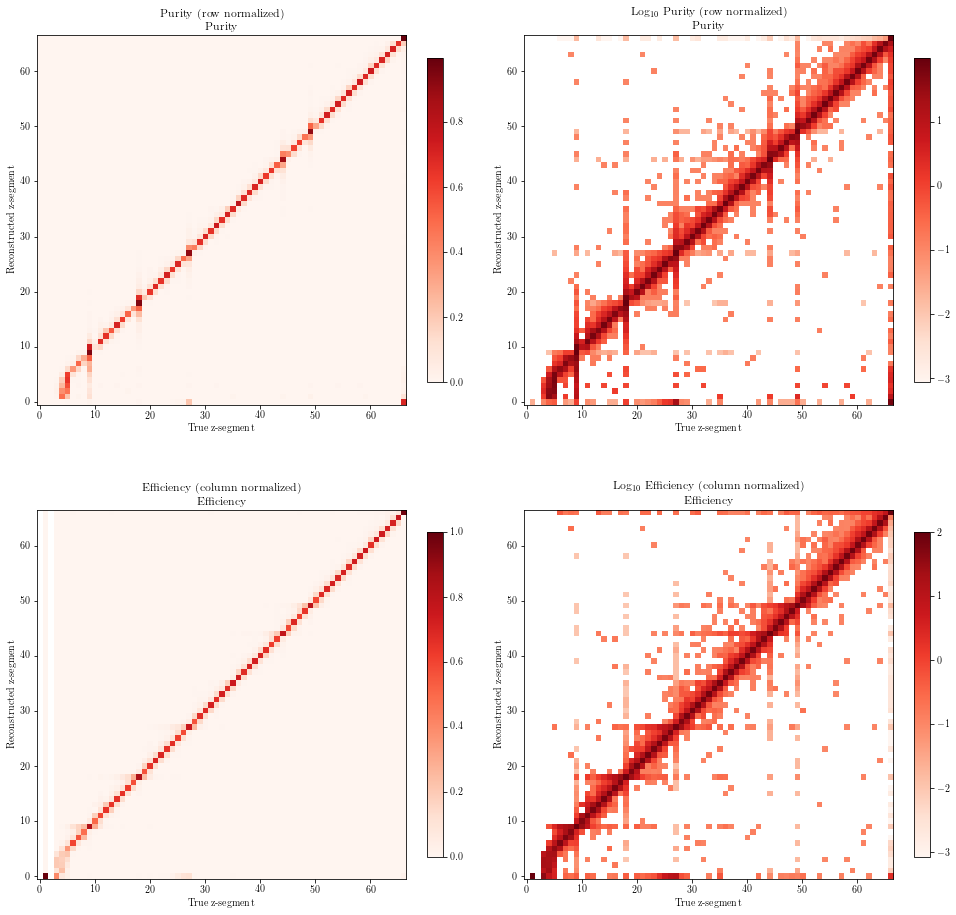

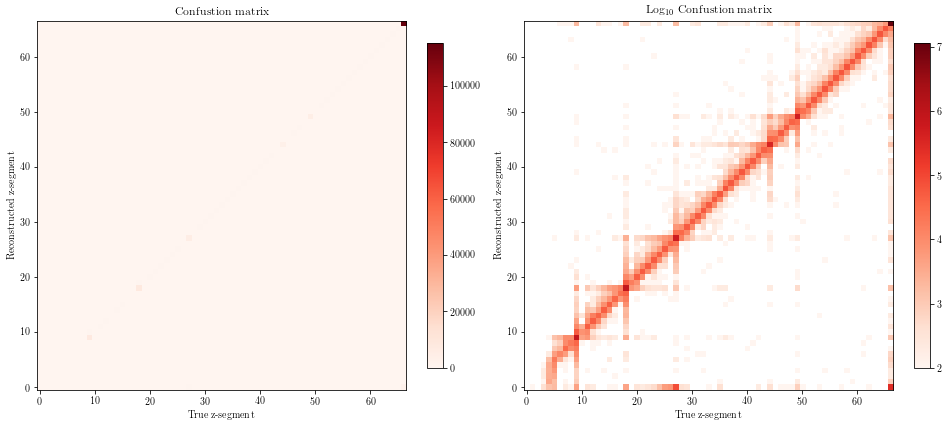

In [20]:
for t in typs:
    do_plots(t)

In [21]:
def do_off_axis_plot_ratios(typ1, typ2):
    arr1_name = 'arr_' + typ1 + '.npy'
    arr2_name = 'arr_' + typ2 + '.npy'
    arr1 = np.load(arr1_name)
    arr2 = np.load(arr2_name)
    np.fill_diagonal(arr1, 0)
    np.fill_diagonal(arr2, 0)
    filename_mod_str1 = 'me1A_' + typ1
    filename_mod_str2 = 'me1A_' + typ2
    # arr1 
    plot_type = 'planecode_energytime_offdiag_' + filename_mod_str1
    make_plots_rowcolnormonly(arr1, plot_type)
    plot_type = 'planecode_energytime_offdiag_' + filename_mod_str1
    make_plots_raw(arr1, plot_type)
    # arr2
    plot_type = 'planecode_energytime_offdiag_' + filename_mod_str2
    make_plots_rowcolnormonly(arr2, plot_type)
    plot_type = 'planecode_energytime_offdiag_' + filename_mod_str2
    make_plots_raw(arr2, plot_type)
    # arr "3"
    arr3 = arr1 / arr2
    plot_type = 'planecode_energytime_offdiag_' + filename_mod_str1 + \
        '_over_' + filename_mod_str2
    make_plots_raw(arr3, plot_type)

/Users/gnperdue/miniconda2/envs/py2mnv_pda/lib/python2.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in divide
  import sys
/Users/gnperdue/miniconda2/envs/py2mnv_pda/lib/python2.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in log10
/Users/gnperdue/miniconda2/envs/py2mnv_pda/lib/python2.7/site-packages/ipykernel_launcher.py:49: RuntimeWarning: divide by zero encountered in log10
/Users/gnperdue/miniconda2/envs/py2mnv_pda/lib/python2.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log10
/Users/gnperdue/miniconda2/envs/py2mnv_pda/lib/python2.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in divide
/Users/gnperdue/miniconda2/envs/py2mnv_pda/lib/python2.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in divide


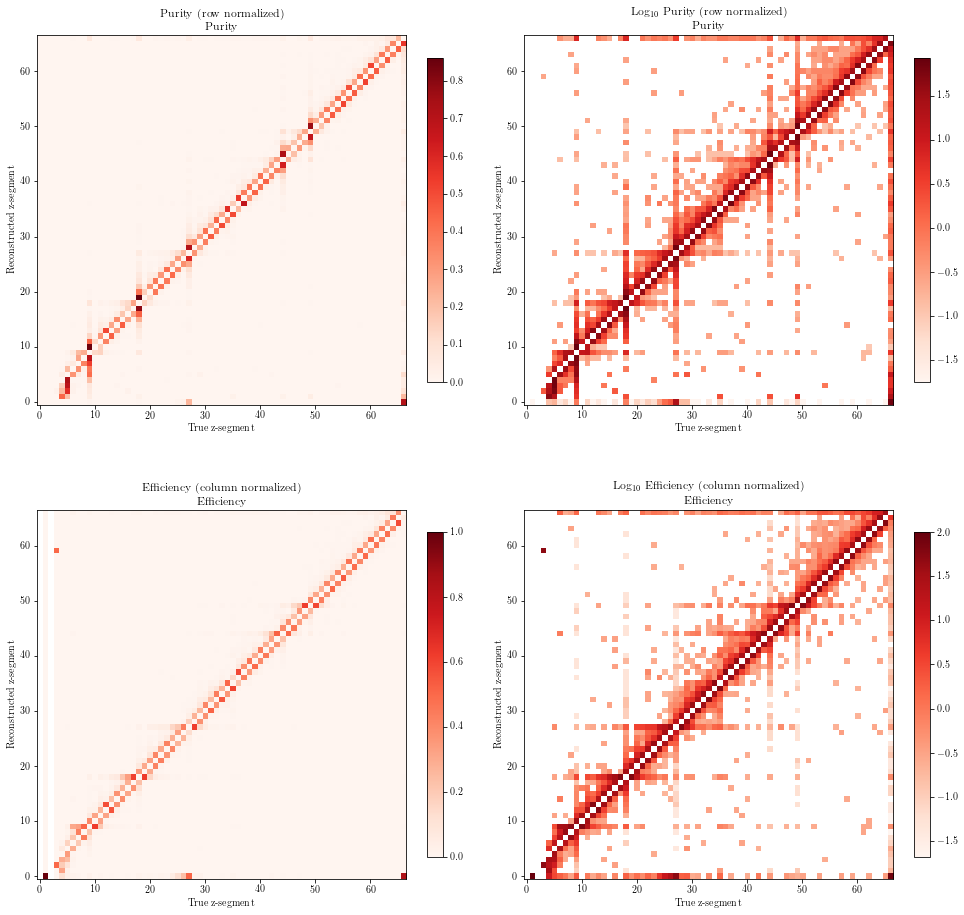

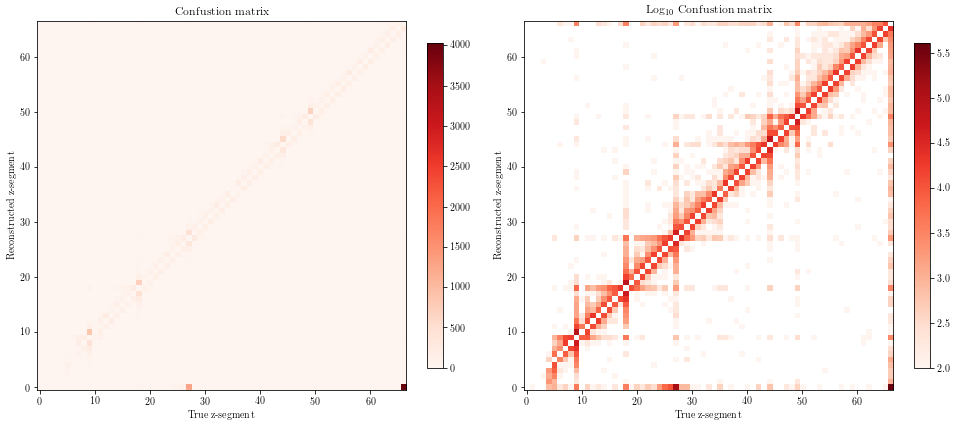

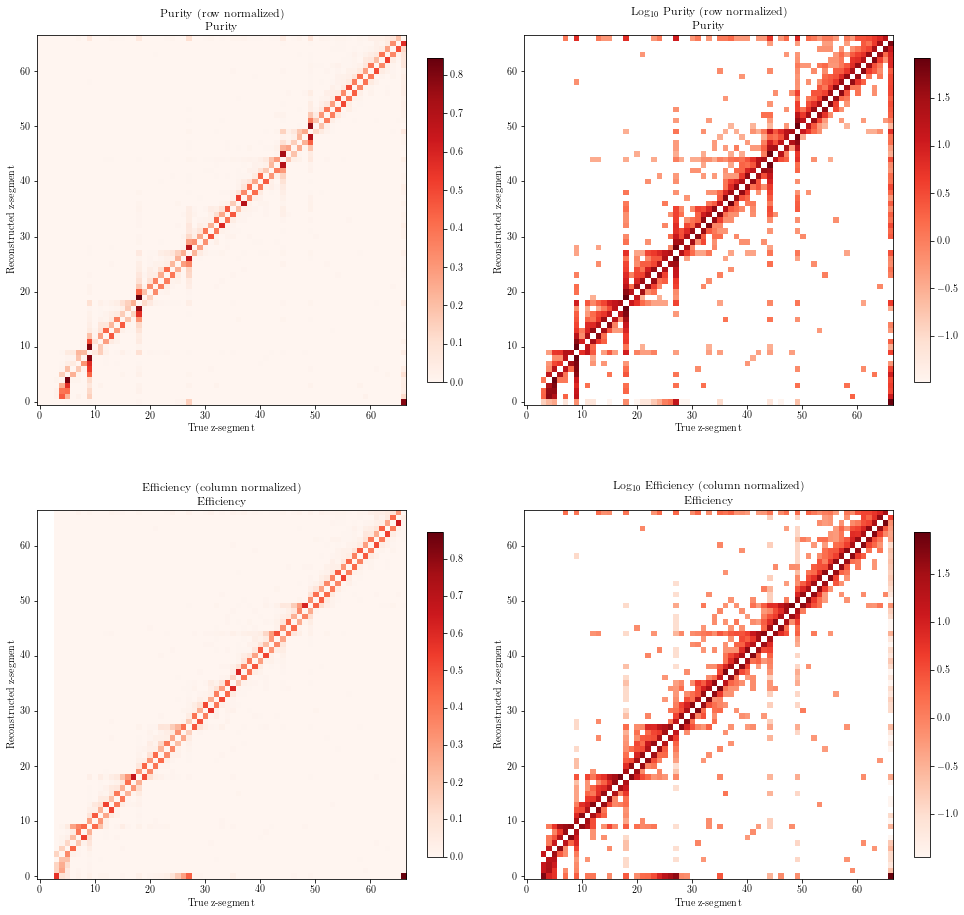

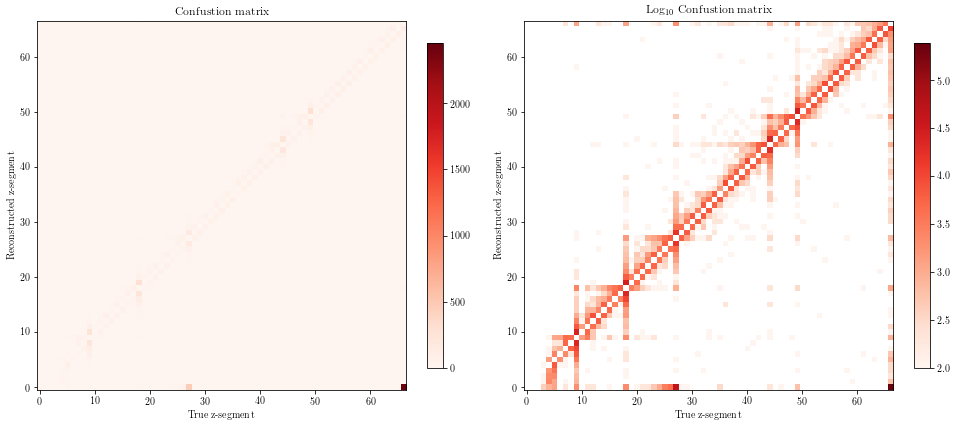

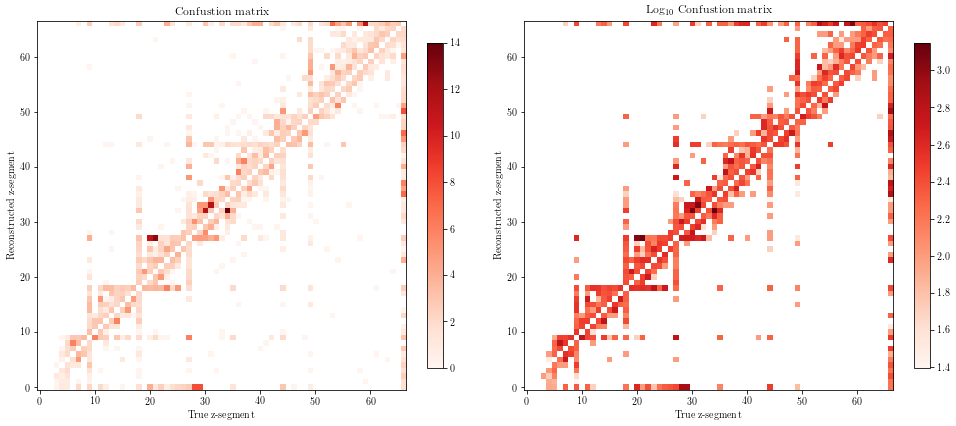

In [22]:
do_off_axis_plot_ratios('lowQ2', 'highQ2')

/Users/gnperdue/miniconda2/envs/py2mnv_pda/lib/python2.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in divide
  import sys
/Users/gnperdue/miniconda2/envs/py2mnv_pda/lib/python2.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in log10
/Users/gnperdue/miniconda2/envs/py2mnv_pda/lib/python2.7/site-packages/ipykernel_launcher.py:49: RuntimeWarning: divide by zero encountered in log10
/Users/gnperdue/miniconda2/envs/py2mnv_pda/lib/python2.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log10
/Users/gnperdue/miniconda2/envs/py2mnv_pda/lib/python2.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in divide
/Users/gnperdue/miniconda2/envs/py2mnv_pda/lib/python2.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in divide


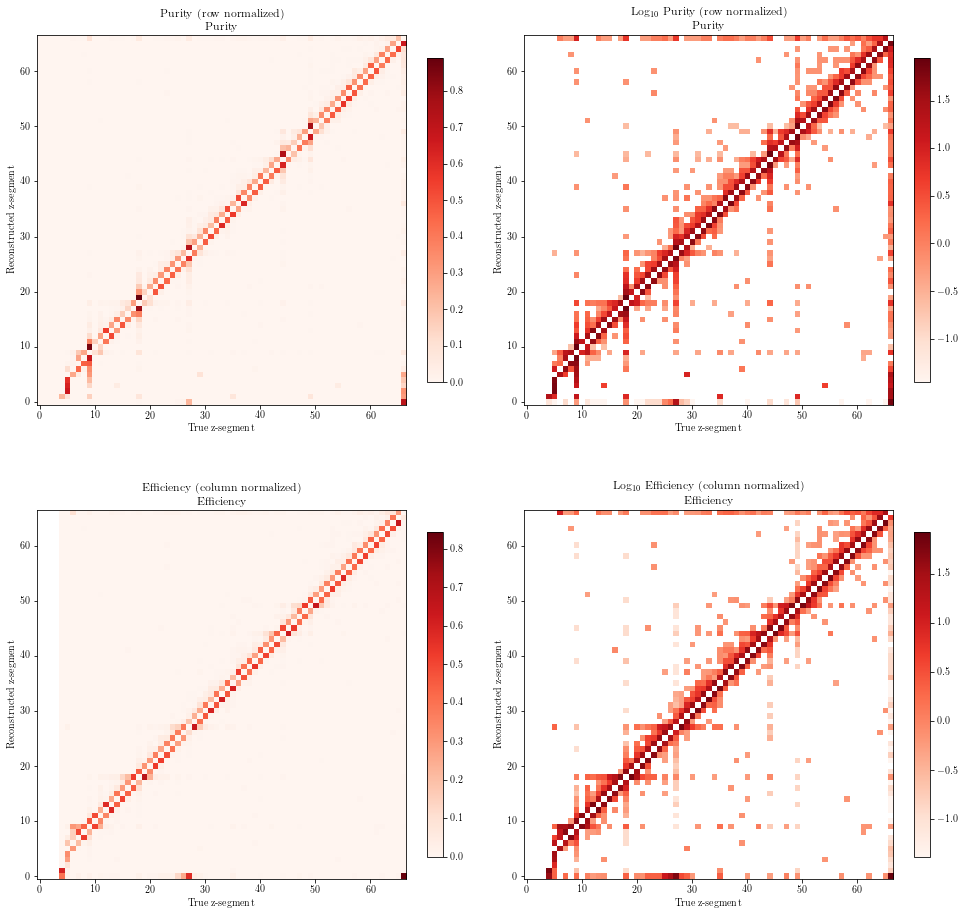

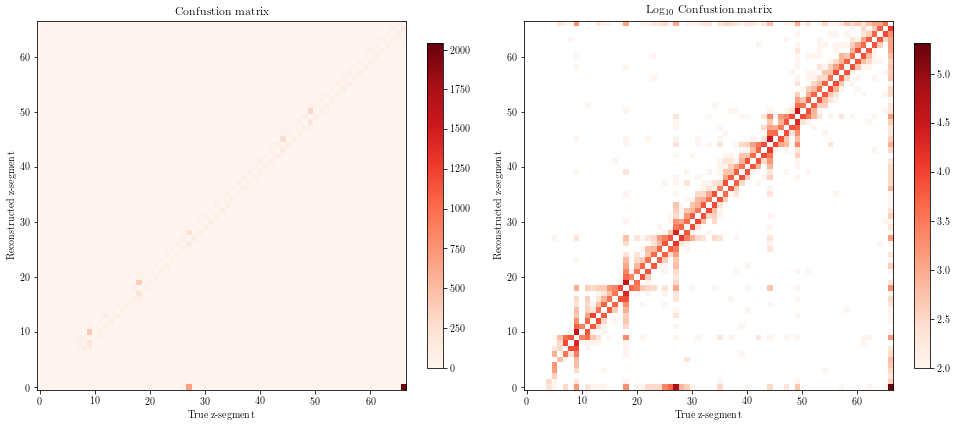

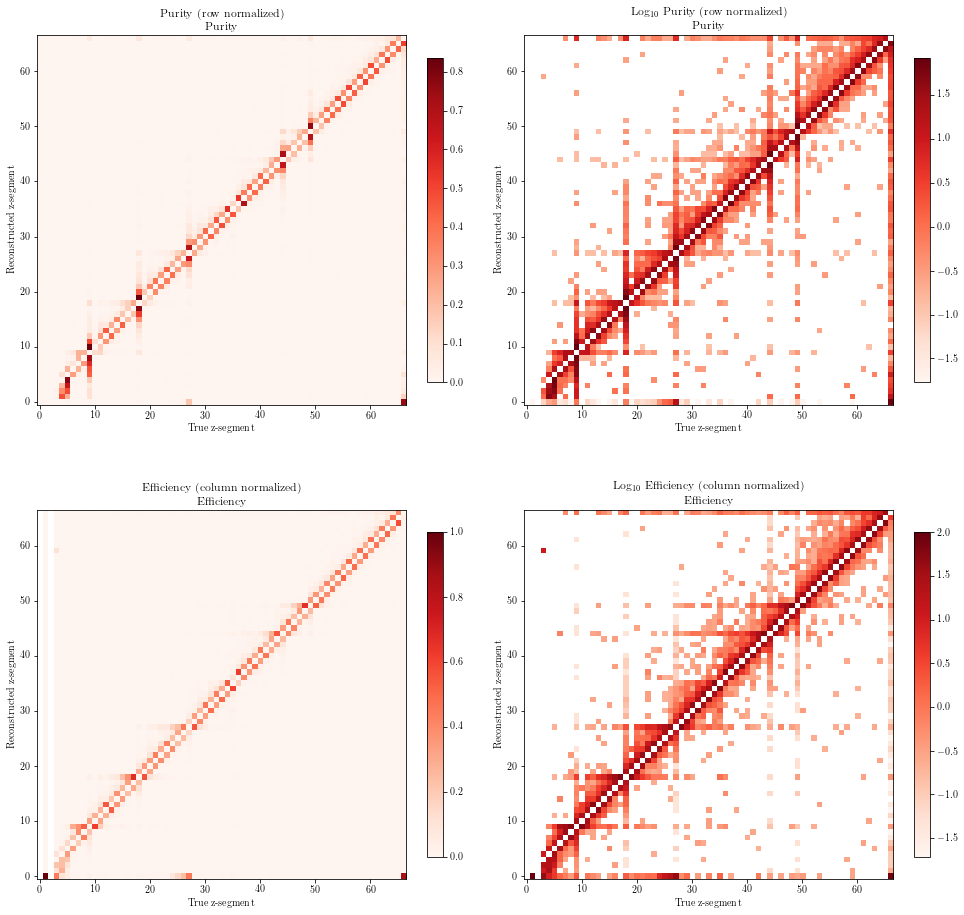

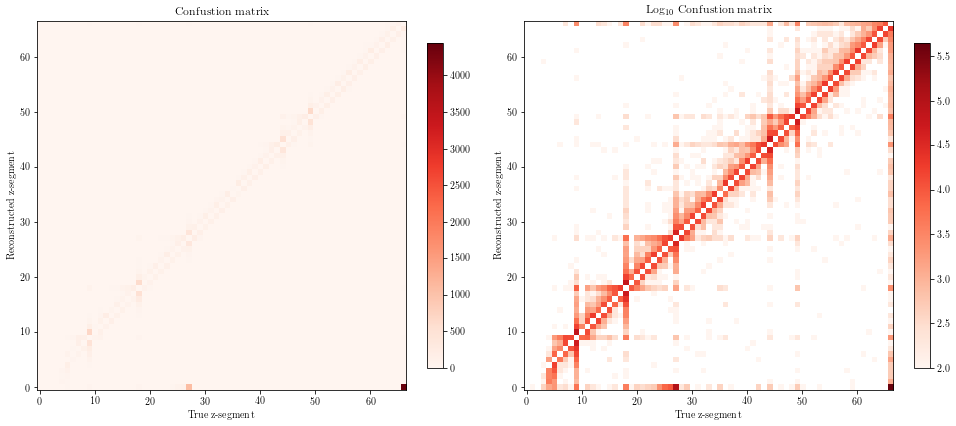

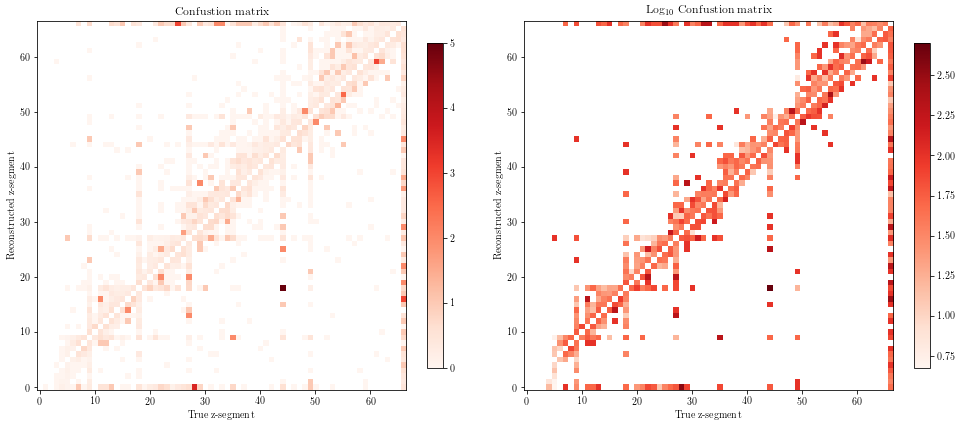

In [23]:
do_off_axis_plot_ratios('lowW', 'highW')

/Users/gnperdue/miniconda2/envs/py2mnv_pda/lib/python2.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in divide
  import sys
/Users/gnperdue/miniconda2/envs/py2mnv_pda/lib/python2.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in log10
/Users/gnperdue/miniconda2/envs/py2mnv_pda/lib/python2.7/site-packages/ipykernel_launcher.py:49: RuntimeWarning: divide by zero encountered in log10
/Users/gnperdue/miniconda2/envs/py2mnv_pda/lib/python2.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log10
/Users/gnperdue/miniconda2/envs/py2mnv_pda/lib/python2.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in divide
/Users/gnperdue/miniconda2/envs/py2mnv_pda/lib/python2.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in divide


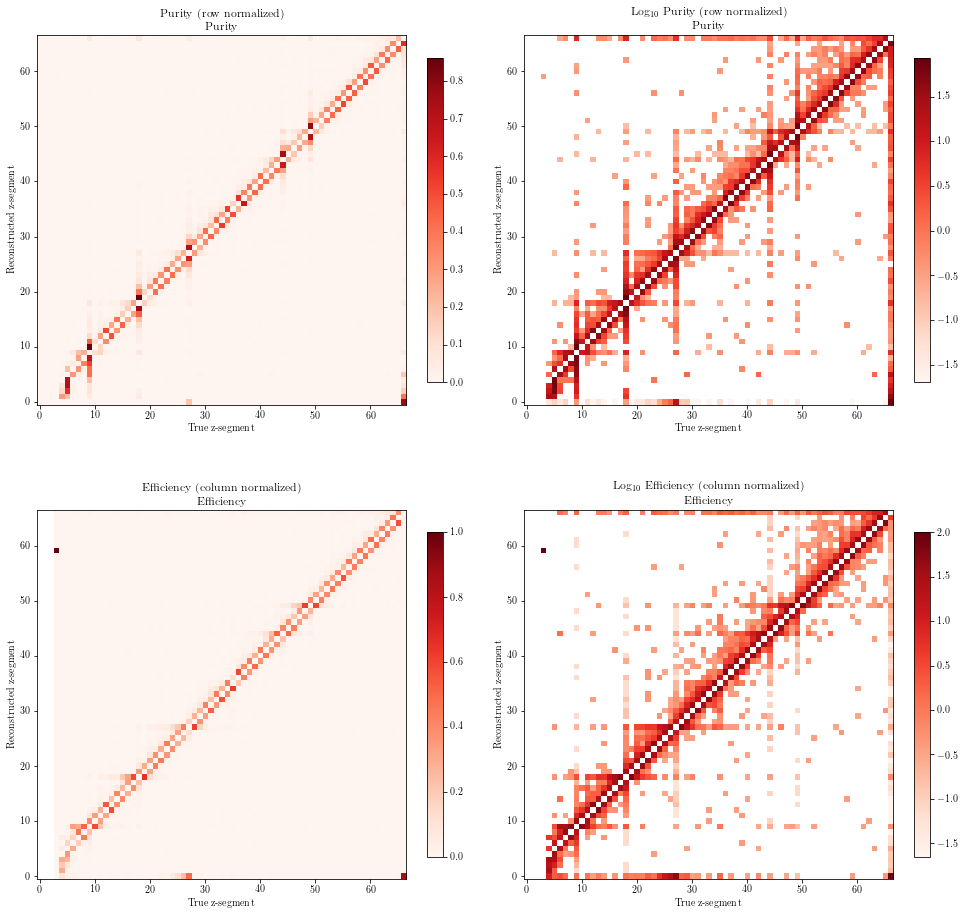

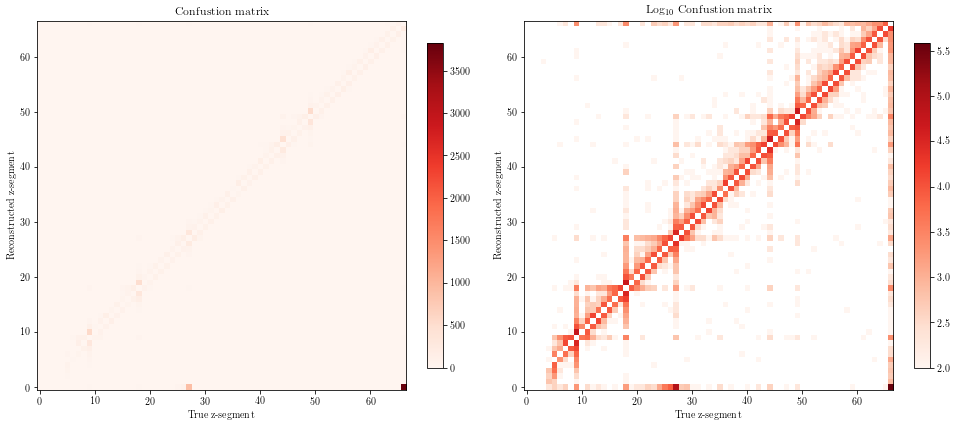

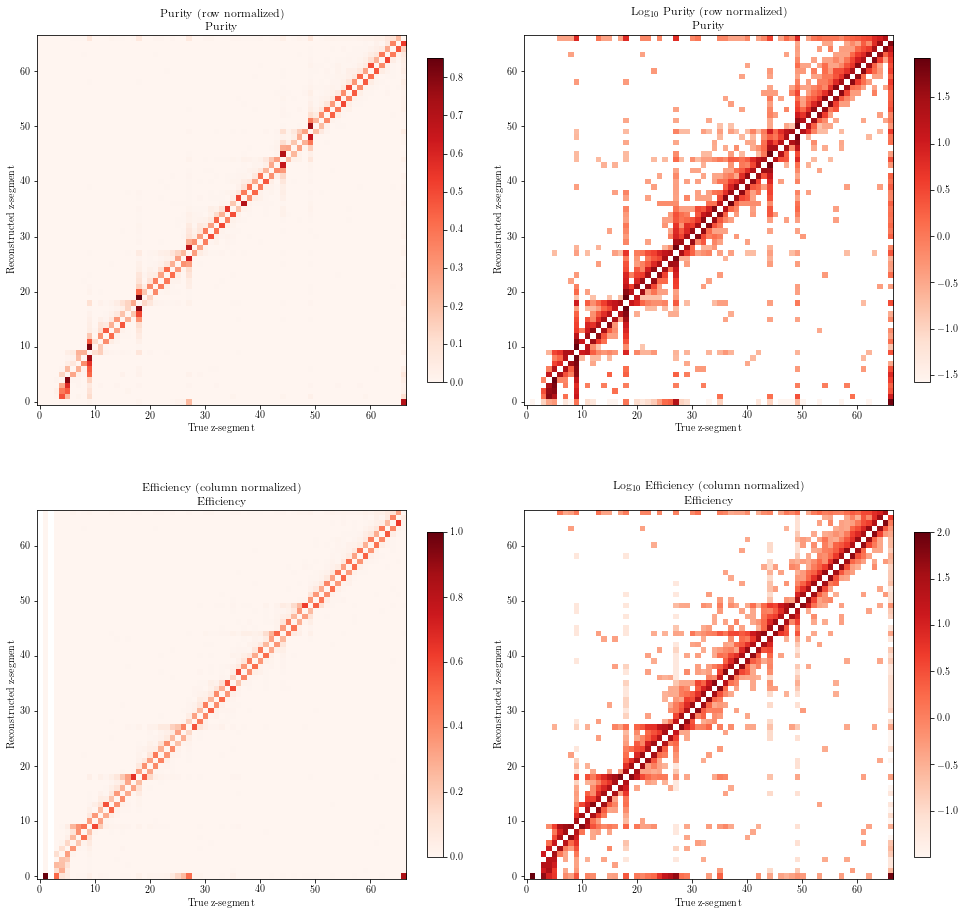

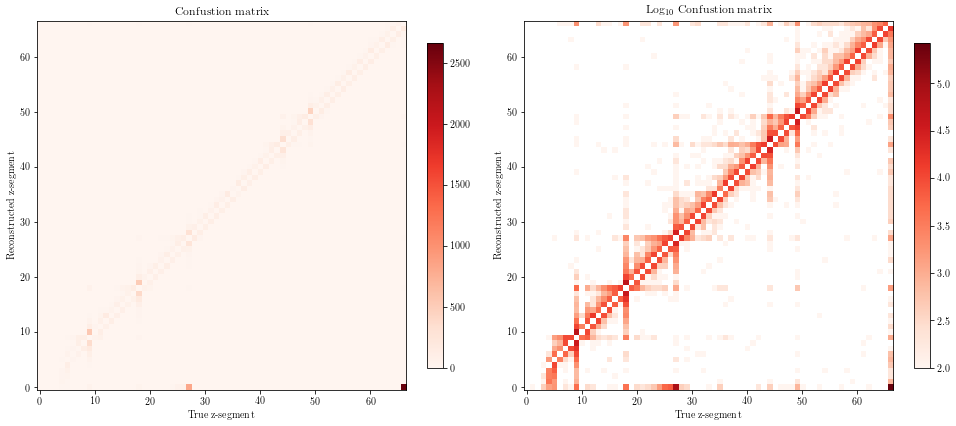

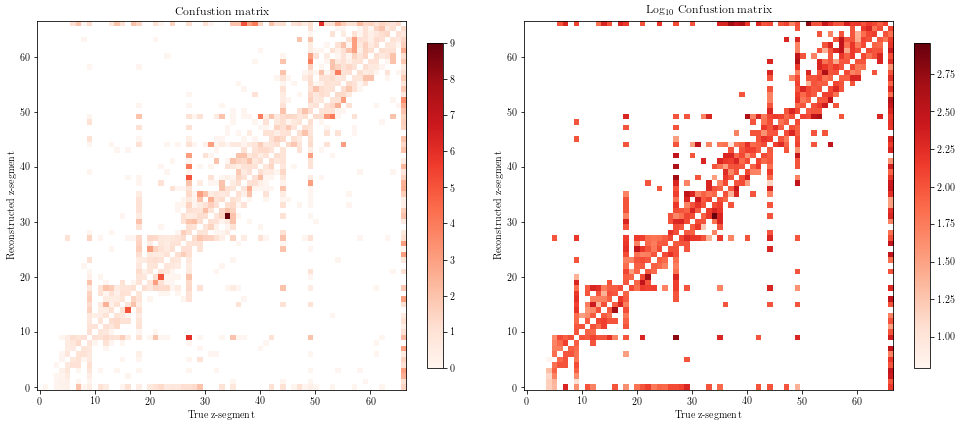

In [24]:
do_off_axis_plot_ratios('lowE', 'highE')